In [1]:
import pandas as pd
import numpy as np
import altair as alt
import pymc as pm
import causalpy as cp
import pymc_bart as pmb
import arviz as az

from utils import *

az.style.use("arviz-doc")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tfr_data = pd.read_csv("./data/tfr2022.csv", index_col=0, sep=';').drop('Country Code', axis=1)

# Clean the data by dropping some groups and countries with too many missing values

tfr_data =  tfr_data.T.iloc[:-2].drop([
    'Central Europe and the Baltics', 
    'Europe & Central Asia (excluding high income)', 
    'Europe & Central Asia',
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'European Union',
    'Euro area',
    'Post-demographic dividend',
    'Channel Islands',
    'Palau',
    'Andorra',
    'San Marino',
    'Liechtenstein',
    'Seychelles',
    'West Bank and Gaza',
    'Greenland',
    'Faroe Islands',
    'Europe & Central Asia (IDA & IBRD countries)'
    ], 
    axis=1).rename(columns={'United Kingdom': 'UK'}).dropna(axis=1, how='all')

tfr_data


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Country Name,Aruba,Afghanistan,Angola,Albania,Arab World,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,...,Virgin Islands (U.S.),Viet Nam,Vanuatu,World,Samoa,Kosovo,Yemen,South Africa,Zambia,Zimbabwe
1960,4.820,7.282,6.708,6.455,6.934332,6.718,3.075,4.786,4.602,3.453,...,5.445,6.280,6.863,4.695854,7.646,6.359,7.938,6.159,7.115,7.220
1961,4.655,7.284,6.790,6.353,6.982115,6.678,3.069,4.670,4.559,3.540,...,4.893,5.476,6.818,4.575587,7.641,6.350,7.963,6.138,7.169,7.233
1962,4.471,7.292,6.872,6.207,7.076112,6.659,3.106,4.521,4.547,3.442,...,4.929,6.274,6.777,5.035173,7.646,6.331,7.963,6.110,7.214,7.255
1963,4.271,7.302,6.954,6.047,7.071542,6.619,3.101,4.345,4.536,3.332,...,4.648,6.385,6.729,5.323428,7.656,6.296,7.981,6.077,7.249,7.253
1964,4.059,7.304,7.036,5.849,7.061969,6.573,3.080,4.150,4.484,3.146,...,5.016,6.285,6.683,5.141420,7.667,6.126,8.038,6.030,7.274,7.261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,1.587,5.002,5.519,1.440,3.279994,1.356,2.039,1.572,1.371,1.740,...,2.060,1.937,3.855,2.397407,4.109,1.605,4.043,2.418,4.536,3.659
2019,1.486,4.870,5.442,1.414,3.224519,1.334,1.994,1.575,1.468,1.657,...,2.050,1.948,3.813,2.360609,4.047,1.546,3.963,2.475,4.451,3.599
2020,1.325,4.750,5.371,1.400,3.186003,1.460,1.911,1.575,1.569,1.581,...,2.030,1.955,3.778,2.299790,3.997,1.529,3.886,2.401,4.379,3.545
2021,1.180,4.643,5.304,1.390,3.142565,1.460,1.885,1.575,1.580,1.700,...,2.010,1.944,3.735,2.273618,3.930,1.522,3.795,2.374,4.308,3.491


In [2]:
target_country = 'Estonia'
treatment_year = 2017
cut_off = 1995

tfr_data.rename_axis(None, axis=1, inplace=True)

cdf = tfr_data[(tfr_data.index.astype('int') > cut_off) & (tfr_data.index.astype('int') < int(treatment_year))].corr()

# Select all countries with 0.8+ correlation between cutoff and treatment into the synthetic control
all_countries = cdf[cdf[target_country] > 0.8].index.tolist()
other_countries = [c for c in all_countries if c != target_country]

tfr_data = tfr_data[tfr_data.index.astype('int') > cut_off][all_countries]

tfr_at_intervention = tfr_data.loc[str(treatment_year), :]
tfr_normalised = (tfr_data.astype('float') / tfr_at_intervention)

tfr_normalised

,Australia,Belgium,Bulgaria,Canada,Czechia,Spain,Estonia,France,UK,Greece,Italy,Kazakhstan,Romania,Sweden
1996,1.031591,0.963636,0.788462,1.051613,0.698225,0.870229,0.861635,0.925926,0.994253,0.933333,0.909091,0.774545,0.730337,0.898876
1997,1.021252,0.969697,0.698718,1.012903,0.692308,0.877863,0.830189,0.936508,0.988506,0.940741,0.924242,0.727273,0.741573,0.853933
1998,1.012062,0.969697,0.711538,1.006452,0.686391,0.862595,0.805031,0.941799,0.982759,0.918519,0.924242,0.654545,0.741573,0.842697
1999,1.008041,0.981818,0.788462,1.000000,0.668639,0.893130,0.817610,0.957672,0.965517,0.911111,0.931818,0.654545,0.730337,0.842697
2000,1.008616,1.012121,0.807692,0.974194,0.680473,0.931298,0.855346,1.000000,0.942529,0.925926,0.954545,0.654545,0.735955,0.865169
2001,0.998851,1.012121,0.775641,0.993548,0.680473,0.938931,0.830189,1.005291,0.936782,0.925926,0.946970,0.690909,0.713483,0.882022
2002,1.008616,1.000000,0.788462,0.980645,0.692308,0.954198,0.855346,0.994709,0.936782,0.948148,0.962121,0.727273,0.713483,0.926966
2003,1.004021,1.012121,0.807692,1.000000,0.698225,0.992366,0.861635,1.000000,0.977011,0.955556,0.977273,0.738182,0.730337,0.960674
2004,1.015508,1.042424,0.852564,1.006452,0.727811,1.000000,0.924528,1.015873,1.005747,0.970370,1.015152,0.803636,0.747191,0.983146
2005,1.037909,1.066667,0.878205,1.019355,0.763314,1.015267,0.955975,1.026455,1.011494,0.992593,1.015152,0.807273,0.786517,0.994382


In [3]:

source = tfr_normalised[all_countries].stack().reset_index().rename(columns={0: 'tfr', 'level_0':'year', 'level_1':'country'})

highlight = alt.selection_point(
    on='mouseover',
    fields=['country'], 
    nearest=True,
    empty=False
)

base = alt.Chart(
    source,
    width=600,
    height=400
).encode(
    x=alt.X('year:Q').axis(format='.0f').scale(domainMin=cut_off+1).title('Year'),
    y=alt.Y('tfr:Q', title='TFR (normalised)').scale(domain=[0.4, 1.5]),
    detail='country:N'
) 

points = base.mark_circle().encode(
    opacity=alt.value(0),
    tooltip='country'
).add_params(
    highlight
)

lines = base.mark_line(
    interpolate='natural'
).encode(
    size=alt.when(highlight).then(alt.value(2)).otherwise(alt.value(1)),
    color=alt.when(highlight).then(alt.value('red')).otherwise(alt.value('lightgray')),
    #color=alt.condition(~highlight, alt.value('lightgray'), alt.value('red')),
    tooltip='country'
)

rule = alt.Chart(pd.DataFrame({
  'aasta': [treatment_year],
  'color': 'red'
})).mark_rule(strokeDash=[1,1]).encode(
  x='aasta:Q',
  color=alt.Color('color:N', scale=None)
)

(points + lines + rule).configure(font='SF Compact Display')

alt.LayerChart(...)

In [12]:
def generate_data(start_year=2005, end_year=2022, treatment_year=2017):
    """
    Generate realistic synthetic data for demonstrating the model.
    
    Parameters:
    -----------
    start_year : int
        First year in the dataset
    end_year : int
        Last year in the dataset
    treatment_year : int
        Year when the treatment happened
        
    Returns:
    --------
    df : DataFrame
        DataFrame with TFR values for Estonia and control countries
    """
    # Create years range
    years = np.arange(start_year, end_year + 1)
    n_years = len(years)
    
    # Country names (Estonia + control countries with high correlation)
    countries = ['Estonia', 'Latvia', 'Lithuania', 'Finland', 'Czech Republic']
    n_countries = len(countries)
    
    # Base TFR trajectories (similar patterns with some correlation)
    np.random.seed(42)
    
    # Create base trend - declining until around 2012-2014, then slightly increasing
    base_trend = np.concatenate([
        np.linspace(1.8, 1.4, years.searchsorted(2012) - years.searchsorted(start_year)),
        np.linspace(1.4, 1.6, years.searchsorted(end_year+1) - years.searchsorted(2012))
    ])
    
    # Generate correlated noise for each country
    corr_matrix = np.array([
        [1.0, 0.8, 0.7, 0.6, 0.7],
        [0.8, 1.0, 0.7, 0.8, 0.4],
        [0.7, 0.7, 1.0, 0.6, 0.5],
        [0.6, 0.8, 0.6, 1.0, 0.4],
        [0.7, 0.4, 0.5, 0.4, 1.0]
    ])
    
    # Cholesky decomposition for generating correlated random variables
    L = np.linalg.cholesky(corr_matrix)
    uncorrelated_noise = np.random.normal(0, 0.1, (n_years, n_countries))
    correlated_noise = np.dot(uncorrelated_noise, L.T)
    
    # Generate data for each country
    data = np.zeros((n_years, n_countries))
    for i in range(n_countries):
        # Each country follows the base trend with some country-specific variation
        country_variation = np.random.normal(0, 0.1)  # Country's base level difference
        data[:, i] = base_trend + country_variation + correlated_noise[:, i]
    
    # Add treatment effect for Estonia after treatment_year
    treatment_idx = years.searchsorted(treatment_year)
    # Linear decrease in treatment effect over time
    treatment_effect = np.zeros(n_years)
    treatment_effect[treatment_idx:] = np.linspace(0.3, 0.1, n_years - treatment_idx)
    data[:, 0] += treatment_effect

    ate = treatment_effect[treatment_idx:] .mean()
    
    # Create DataFrame
    df = pd.DataFrame(data, index=years, columns=countries)
    
    return df, treatment_year, ate

df, _, ate = generate_data(start_year=1995, end_year=2023, treatment_year=2017)

print('True average treatment effect:', ate)
df.plot(backend='hvplot')


True average treatment effect: 0.2


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [13]:

def create_synthetic_control_model(X_control, y_treated_pre, y_treated_post=None):
    """
    Set up a PyMC model for synthetic control analysis.
    
    Parameters:
    -----------
    X_control : numpy.ndarray
        Array of shape (n_time_periods_pre + n_time_periods_post, n_control_units)
        Contains TFRs for control countries for both pre and post treatment periods
    y_treated_pre : numpy.ndarray
        Array of shape (n_time_periods_pre,)
        Contains Estonia's TFR values for pre-treatment period
    y_treated_post : numpy.ndarray, optional
        Array of shape (n_time_periods_post,)
        Contains Estonia's TFR values for post-treatment period
        
    Returns:
    --------
    PyMC model
    """
    
    n_control_units = X_control.shape[1]
    n_time_pre = len(y_treated_pre)
    
    # Split control data into pre and post periods
    X_control_pre = X_control[:n_time_pre]
    X_control_post = X_control[n_time_pre:] if X_control.shape[0] > n_time_pre else None
    
    with pm.Model() as model:
        
        # Prior for control weights (Dirichlet ensures weights sum to 1)
        beta = pm.Dirichlet('beta', a=np.ones(n_control_units))
        
        # Prior for observation noise
        sigma = pm.HalfNormal('sigma', sigma=0.1)
        
        # Deterministic prediction for pre-treatment period
        mu_pre = pm.Deterministic('mu_pre', pm.math.dot(X_control_pre, beta))
        
        # Likelihood for pre-treatment period (observed data)
        y_pre = pm.Normal('y_pre', mu=mu_pre, sigma=sigma, observed=y_treated_pre)
        
        # If we have post-treatment data, set up predictions for counterfactual
        if X_control_post is not None and y_treated_post is not None:
            # Deterministic prediction for post-treatment (counterfactual)
            mu_post = pm.Deterministic('mu_post', pm.math.dot(X_control_post, beta))
            
            # Compute treatment effect
            treatment_effect = pm.Deterministic('treatment_effect', 
                                              y_treated_post - mu_post)
            
            # Average treatment effect
            avg_treatment_effect = pm.Deterministic('avg_treatment_effect', 
                                                    pm.math.mean(treatment_effect))
            
    return model

def fit_model(model, samples=2000, tune=1000, chains=4, target_accept=0.9):

    with model:
        trace = pm.sample(samples, tune=tune, chains=chains, 
                          target_accept=target_accept)
    return trace



In [14]:
df, treatment_year, _ = generate_data(start_year=1995, end_year=2023, treatment_year=2017)

#df = tfr_data.copy()
#df.index = df.index.astype(int)

print("Example Data (TFR by country and year):")
print(df.head())

# Prepare data for model
X_control, estonia_pre, estonia_post, control_countries, pre_years, post_years = prepare_data(
    df, 'Estonia', treatment_year
)

print("\nControl countries:", control_countries)
print(f"Pre-treatment years: {pre_years[0]}-{pre_years[-1]}")
print(f"Post-treatment years: {post_years[0]}-{post_years[-1]}")


# Create and fit model
model = create_synthetic_control_model(X_control, estonia_pre, estonia_post)
trace = fit_model(model, samples=1000, tune=500)  # Reduced samples for demonstration

# Print summary statistics
print("\nModel Summary:")
summary = pm.summary(trace, var_names=['beta', 'sigma', 'avg_treatment_effect'])
print(summary)

# Print control country weights 
print("\nControl Country Weights:")
# Extract beta means from the summary DataFrame
beta_means = summary.loc[[b for b in summary.index if b.startswith('beta')], 'mean'].values
for country, weight in zip(control_countries, beta_means):
    print(f"{country}: {weight:.3f}")

print(f"\nEstimated Average Treatment Effect: {summary.loc['avg_treatment_effect', 'mean']:.3f}")


Initializing NUTS using jitter+adapt_diag...


Example Data (TFR by country and year):
       Estonia    Latvia  Lithuania   Finland  Czech Republic
1995  1.927854  1.707746   1.743214  1.969901        1.889701
1996  1.829769  1.727327   1.715211  1.875961        1.779300
1997  1.781841  1.561288   1.590979  1.638548        1.617727
1998  1.746954  1.495552   1.551172  1.638400        1.640010
1999  1.924747  1.680010   1.669839  1.744505        1.777655

Control countries: ['Latvia', 'Lithuania', 'Finland', 'Czech Republic']
Pre-treatment years: 1995-2016
Post-treatment years: 2017-2023


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.



Model Summary:
                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[0]               0.040  0.040   0.000    0.112      0.001    0.001   
beta[1]               0.040  0.038   0.000    0.107      0.001    0.001   
beta[2]               0.657  0.139   0.400    0.904      0.002    0.002   
beta[3]               0.263  0.140   0.001    0.496      0.002    0.002   
sigma                 0.085  0.014   0.060    0.111      0.000    0.000   
avg_treatment_effect  0.245  0.012   0.225    0.267      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
beta[0]                 1960.0    1327.0    1.0  
beta[1]                 1391.0     898.0    1.0  
beta[2]                 3103.0    2193.0    1.0  
beta[3]                 3297.0    1575.0    1.0  
sigma                   2250.0    2287.0    1.0  
avg_treatment_effect    2575.0    2782.0    1.0  

Control Country Weights:
Latvia: 0.040
Lithuania: 0.040
Finland: 0.657
Czech Republic: 0.263

Estimated Ave

<Axes: title={'center': 'avg_treatment_effect'}>

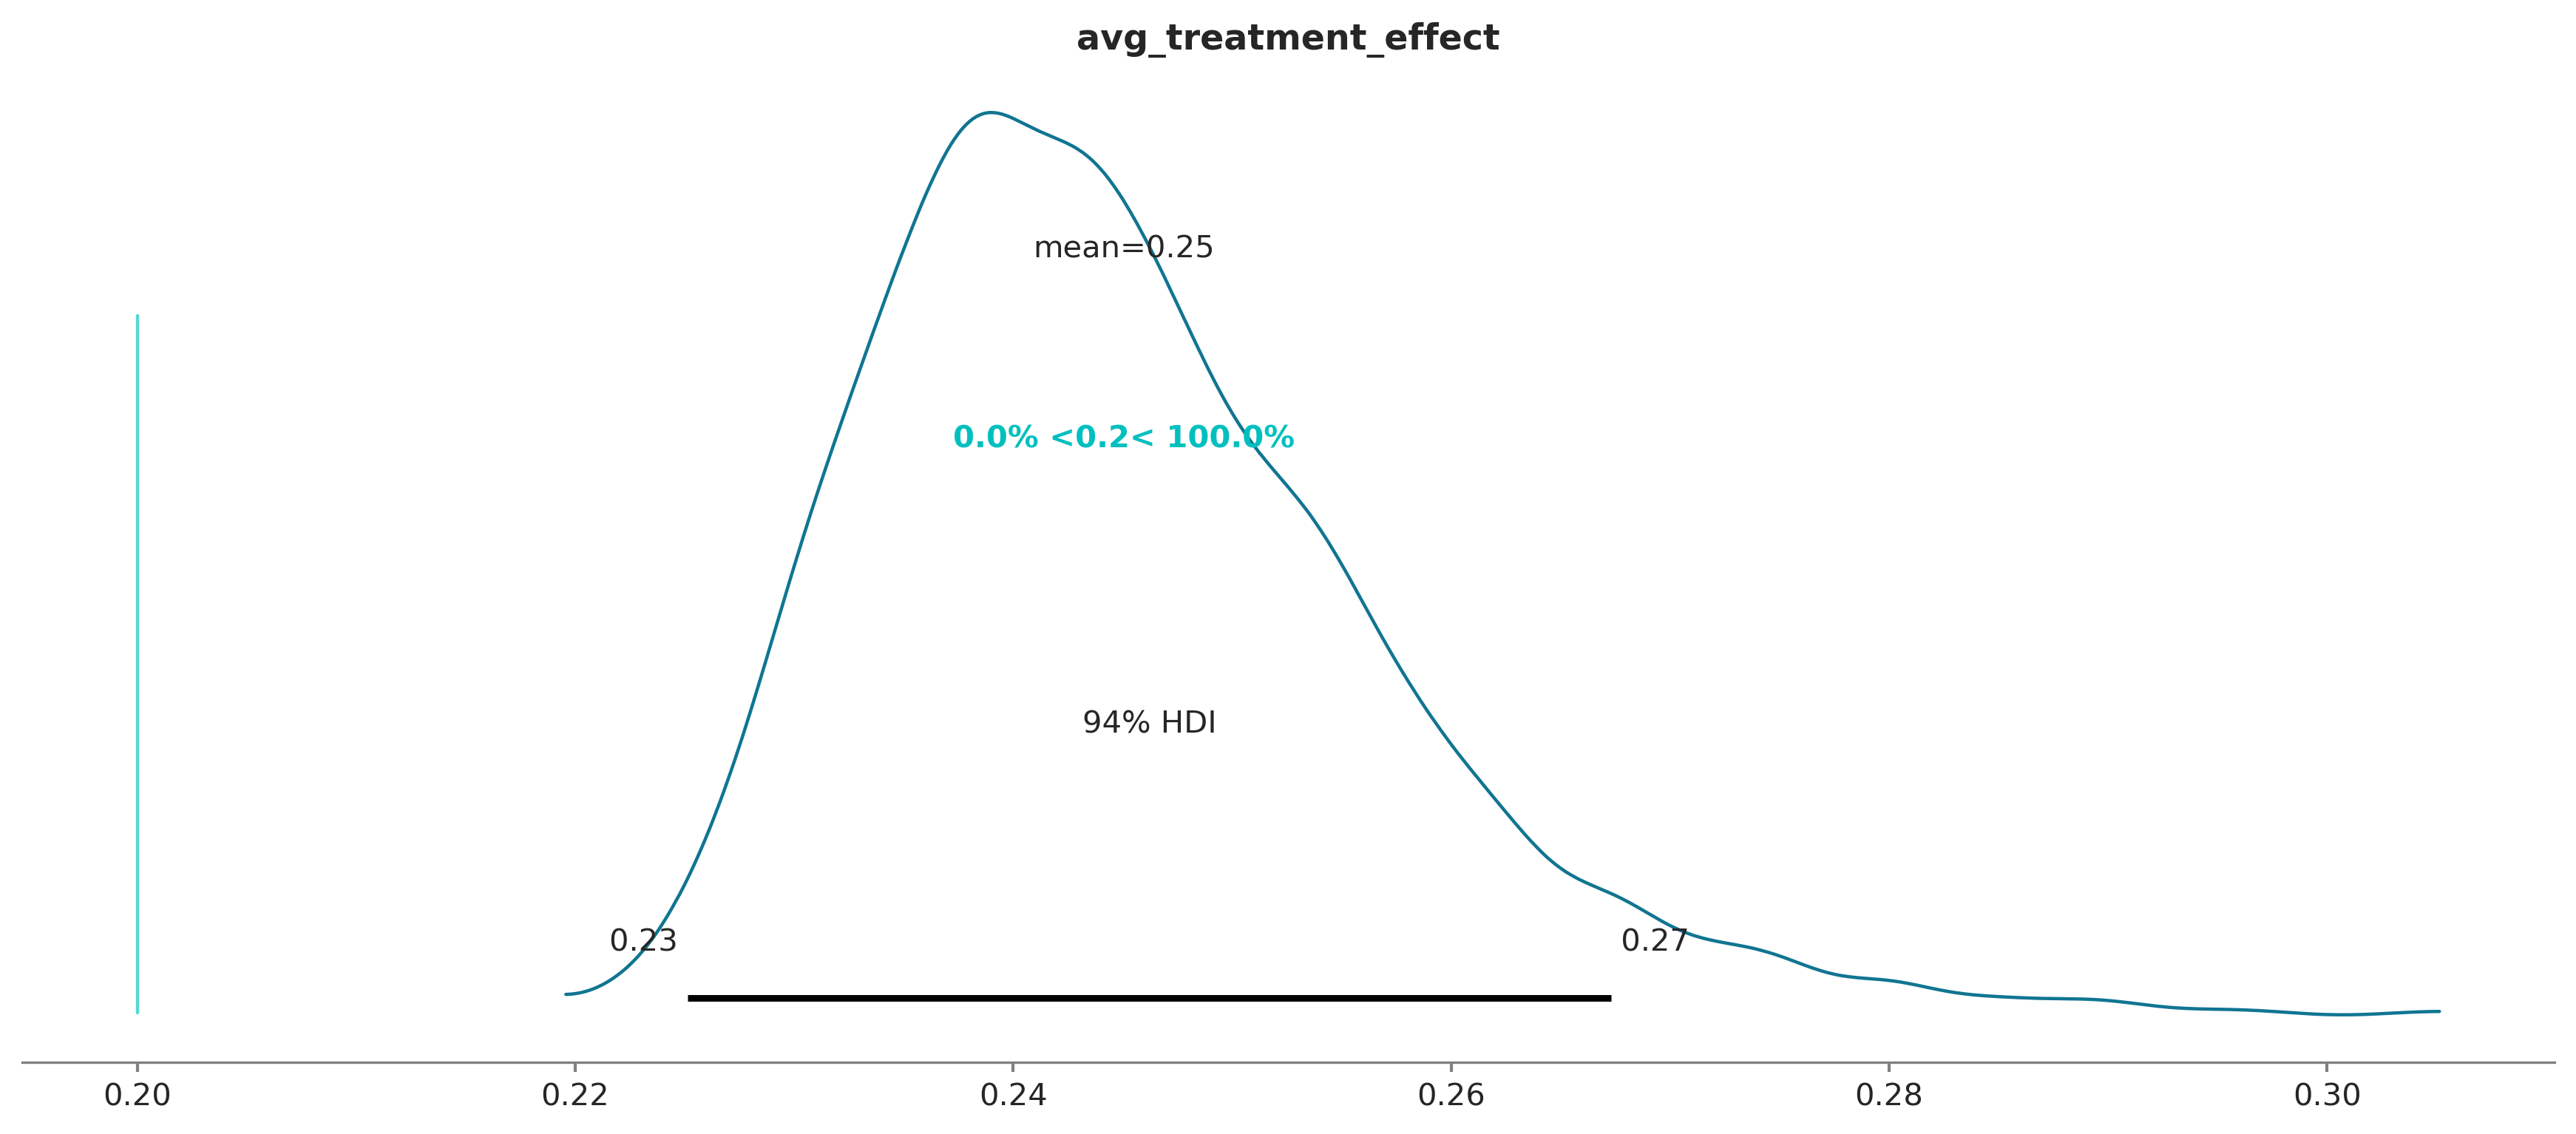

In [15]:
pm.plot_posterior(trace, var_names=['avg_treatment_effect'], ref_val=ate, textsize=10)

<Axes: >

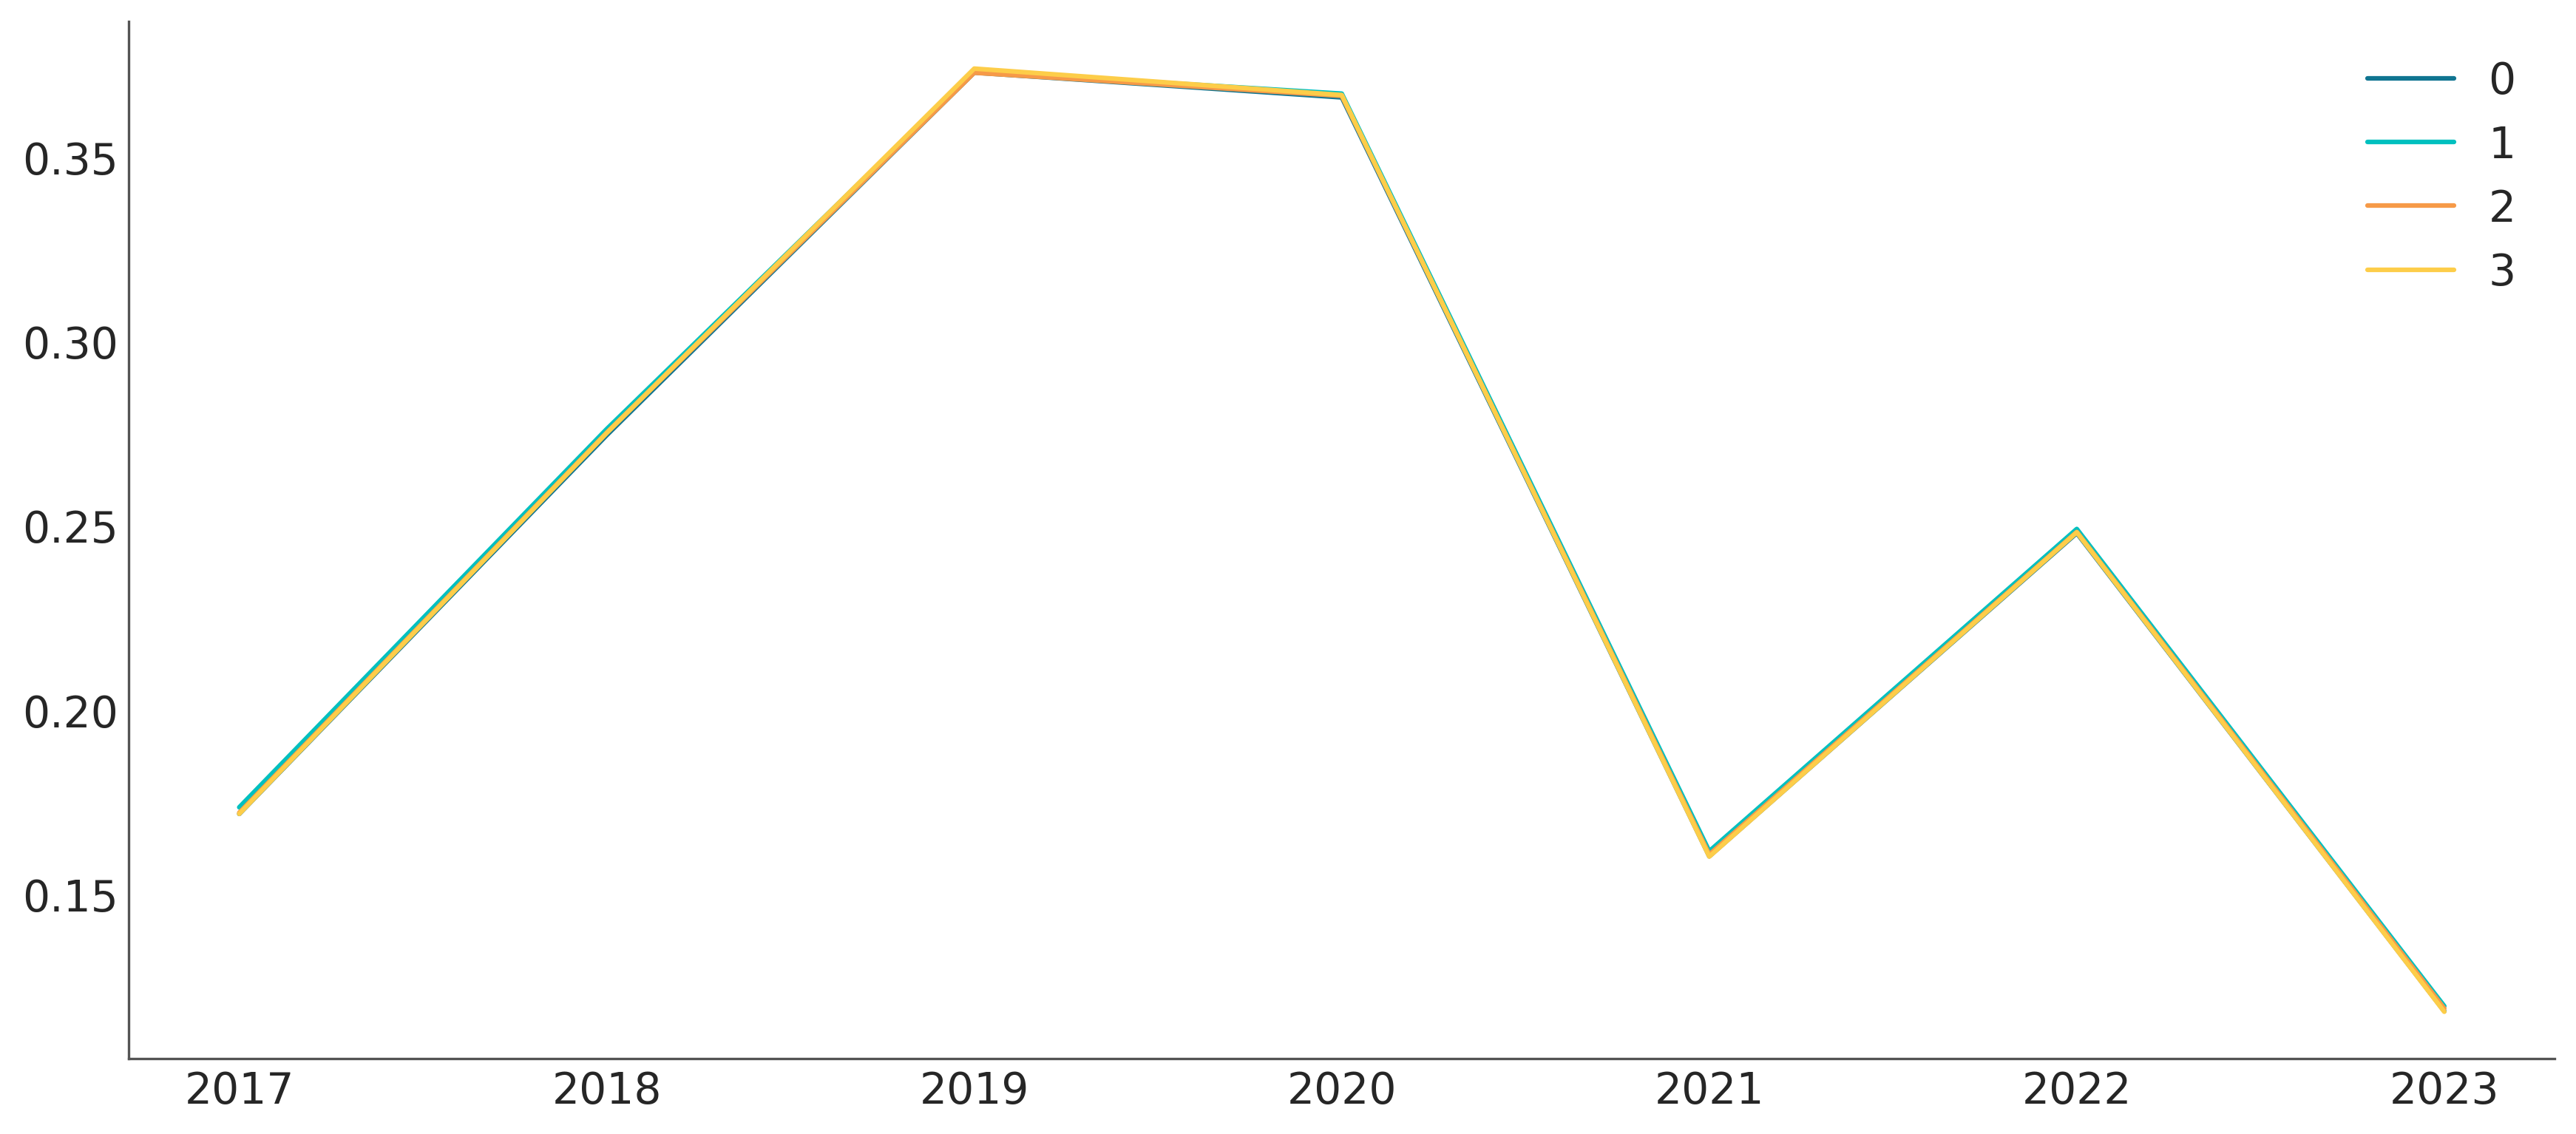

In [16]:
pd.DataFrame(trace.posterior.treatment_effect.mean(axis=1), columns=post_years).T.plot() 

In [17]:
   # Create and display the visualization
plot_treatment_effect(df, trace, 'Estonia', control_countries, treatment_year)

alt.HConcatChart(...)

In [18]:
# OK, let's work with the real data now

df = tfr_data.copy()
df.index = df.index.astype(int)

X_control, estonia_pre, estonia_post, control_countries, pre_years, post_years = prepare_data(
    df, 'Estonia', treatment_year
)

print("\nControl countries:", control_countries)
print(f"Pre-treatment years: {pre_years[0]}-{pre_years[-1]}")
print(f"Post-treatment years: {post_years[0]}-{post_years[-1]}")


# Create and fit model
model = create_synthetic_control_model(X_control, estonia_pre, estonia_post)
trace = fit_model(model, samples=1000, tune=500)  # Reduced samples for demonstration

# Print summary statistics
print("\nModel Summary:")
summary = pm.summary(trace, var_names=['beta', 'sigma', 'avg_treatment_effect'])
print(summary)

# Print control country weights 
print("\nControl Country Weights:")
# Extract beta means from the summary DataFrame
beta_means = summary.loc[[b for b in summary.index if b.startswith('beta')], 'mean'].values
for country, weight in zip(control_countries, beta_means):
    print(f"{country}: {weight:.3f}")

print(f"\nEstimated Average Treatment Effect: {summary.loc['avg_treatment_effect', 'mean']:.3f}")



Initializing NUTS using jitter+adapt_diag...



Control countries: ['Australia', 'Belgium', 'Bulgaria', 'Canada', 'Czechia', 'Spain', 'France', 'UK', 'Greece', 'Italy', 'Kazakhstan', 'Romania', 'Sweden']
Pre-treatment years: 1996-2016
Post-treatment years: 2017-2022


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=29061) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.



Model Summary:
                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[0]               0.039  0.034   0.000    0.103      0.001    0.001   
beta[1]               0.048  0.042   0.000    0.126      0.001    0.001   
beta[2]               0.217  0.121   0.001    0.410      0.003    0.002   
beta[3]               0.038  0.035   0.000    0.102      0.001    0.001   
beta[4]               0.104  0.083   0.000    0.252      0.002    0.001   
beta[5]               0.102  0.081   0.000    0.248      0.001    0.001   
beta[6]               0.027  0.025   0.000    0.075      0.000    0.000   
beta[7]               0.041  0.036   0.000    0.110      0.001    0.001   
beta[8]               0.136  0.096   0.000    0.303      0.002    0.001   
beta[9]               0.072  0.064   0.000    0.190      0.001    0.001   
beta[10]              0.041  0.028   0.000    0.090      0.000    0.000   
beta[11]              0.062  0.057   0.000    0.170      0.001    0.001   
beta[12] 

In [19]:
plot_treatment_effect(df, trace, 'Estonia', control_countries, treatment_year)

alt.HConcatChart(...)

In [ ]:

pm.plot_posterior(trace, var_names=['avg_treatment_effect'], ref_val=0, textsize=10)

### 

<img src="./life.png">


In [ ]:
import causalpy as cp

formula = target_country + " ~ " + "0 + " + " + ".join(other_countries)

formula

In [ ]:
treatment_time = pd.to_datetime('2017-01-01')

#Causalpy requires the index column be in DatetimeIndex format
data = df.copy()
data.index = pd.to_datetime(data.index.astype(str)+"-01-01")

sample_kwargs = {"tune": 4000, "target_accept": 0.95, 'nuts_sampler': 'nutpie'}

result = cp.SyntheticControl(
    data,
    treatment_time,
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(sample_kwargs=sample_kwargs),
)

In [ ]:
result.plot()

In [ ]:
pm.summary(result.idata)